In [31]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
# used for performing the augmented Dickey-Fuller test
from statsmodels.tsa.seasonal import seasonal_decompose
# used for decomposing a time series into its trend, seasonal, and residual components.
from statsmodels.tsa.stattools import acf, pacf
# used for analyzing the autocorrelation and partial autocorrelation of a time series.
from statsmodels.tsa.arima_model import ARIMA
from statsmodels import api as sm

!pip install --upgrade statsmodels


Defaulting to user installation because normal site-packages is not writeable


In [4]:
airpass = pd.read_csv('C:/Users/bhavi/OneDrive/Desktop/AirPassengers.csv')
airpass
# This is time series data .
# where there is only one entity and given sequence of time.
# lets check some record

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [1]:
airpass.info()

NameError: name 'df_co2' is not defined

In [6]:
# need to change the data type of month
from datetime import datetime
airpass['Month']=pd.to_datetime(airpass['Month'],infer_datetime_format=True)
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [7]:
# setting month column to an index
airpassind = airpass.set_index('Month',inplace=False)
airpassind.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


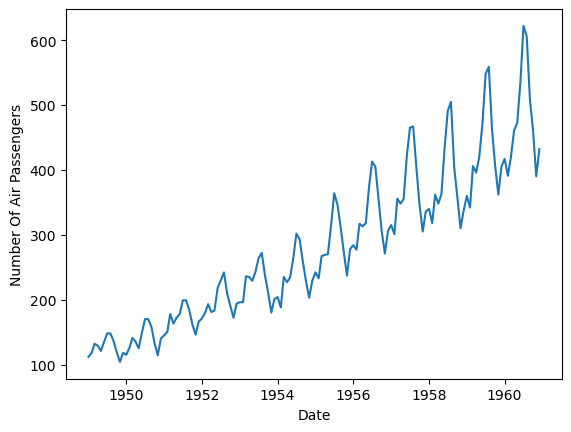

In [8]:
plt.xlabel('Date')
plt.ylabel('Number Of Air Passengers')
plt.plot(airpassind)

In [9]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(airpassind['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
   

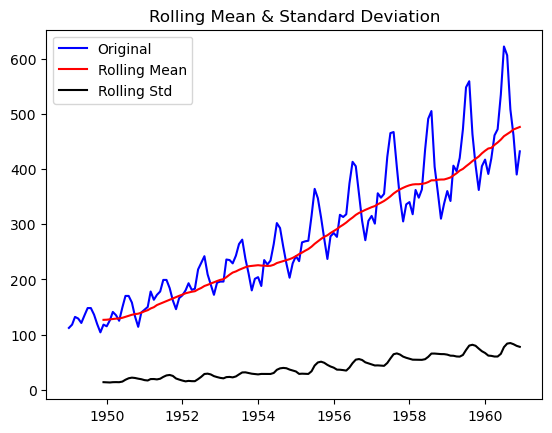

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(airpassind)
#  based on the high p-value and the test statistic being greater than the critical values, 
#we fail to reject the null hypothesis, and we conclude that the time series is likely non-stationary.

In [11]:
# Data Transformation To Achieve Stationarity
# Now, we will have to perform some data transformation to achieve Stationarity. 
# We can perform any of the transformations like taking 
# log scale, square, square root, cube, cube root, time shift, exponential decay etc.

In [12]:
# Let's perform Log Transformation

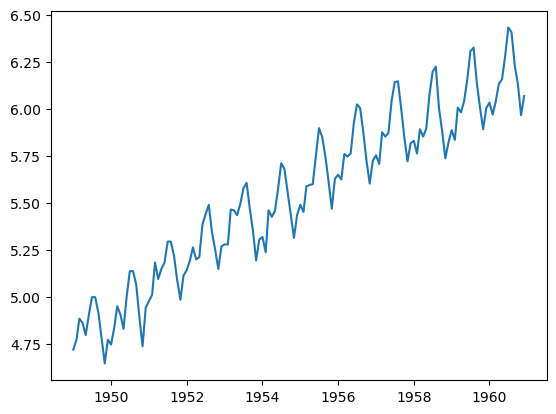

In [13]:
airpass_log = np.log(airpassind)
plt.plot(airpass_log)

In [14]:
rollmean_log = airpass_log.rolling(window=12).mean()
rollstd_log = airpass_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

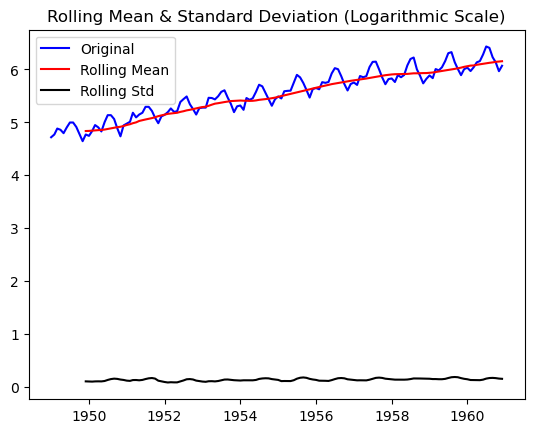

In [15]:
plt.plot(airpass_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

In [16]:
airpass_log_diff= airpass_log - rollmean_log

In [17]:
# here we are dropping null values.
airpass_log_diff.dropna(inplace=True)
airpass_log_diff.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


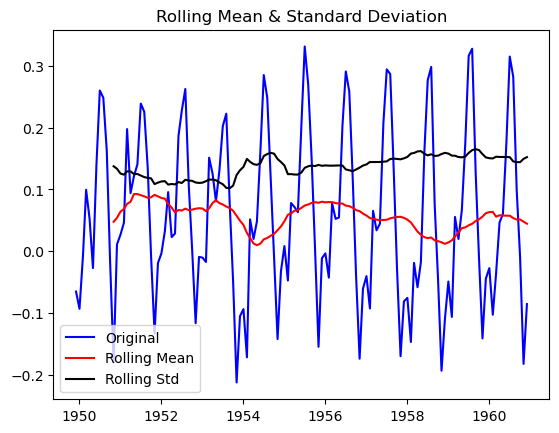

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
# here we are using our pre defined function
test_stationarity(airpass_log_diff)

In [19]:
# confidence intervals are pretty close to the Test Statistic
# we can now see that SD and Mean are constant in nature.
# so our model is Stationary now.

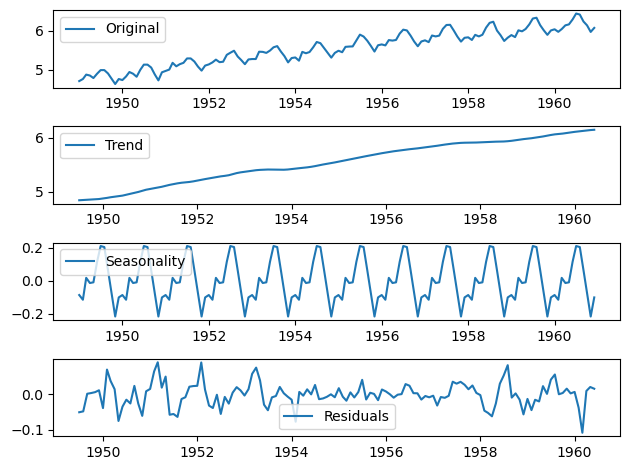

In [20]:
decomposition = seasonal_decompose(airpass_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(airpass_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

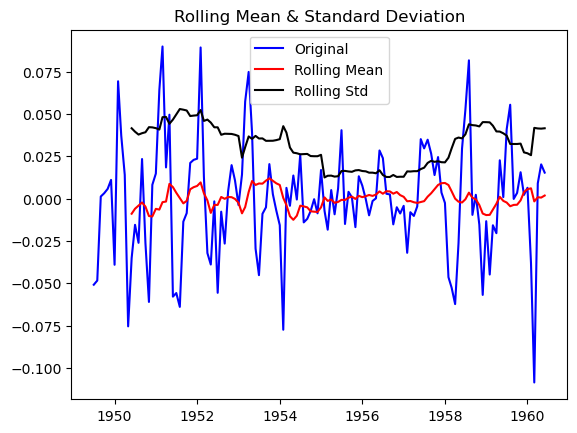

In [21]:
# There can be cases where an observation simply consist of trend & seasonality. 
# In that case, there won't be any residual component & that would be a null or NaN. 
# Hence, we also remove such cases.
residual = decomposition.resid
airpass_decompose = residual
airpass_decompose.dropna(inplace=True)
rollmean_decompose = airpass_decompose.rolling(window=12).mean()
rollstd_decompose = airpass_decompose.rolling(window=12).std()

plt.plot(airpass_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [22]:
lag_acf = acf(airpass_log_diff, nlags=20)
lag_pacf = pacf(airpass_log_diff, nlags=20, method='ols')

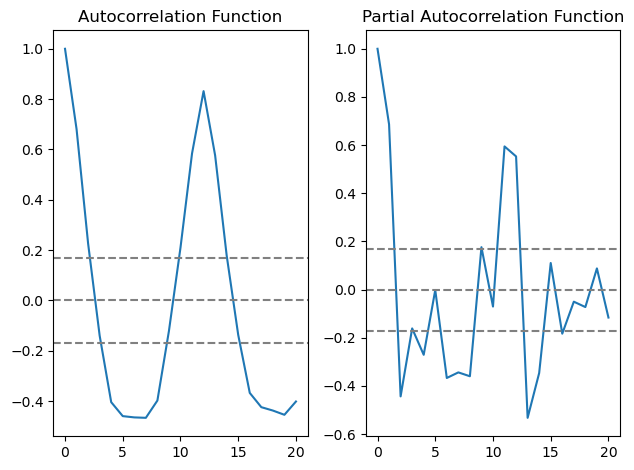

In [23]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            


#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

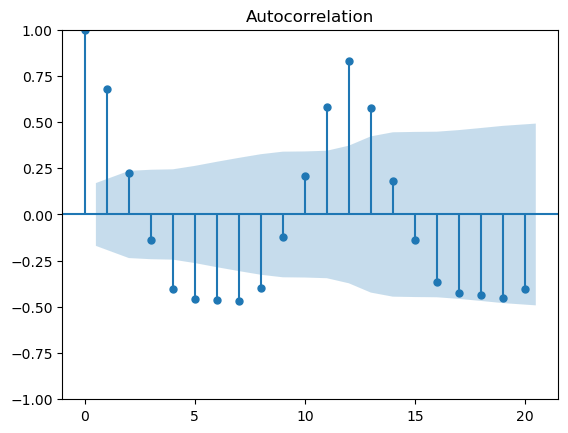

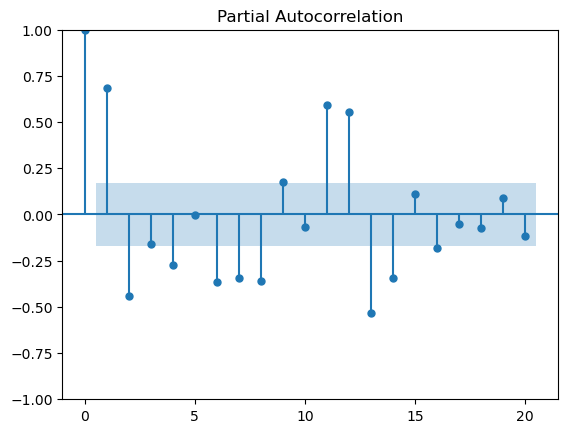

In [32]:
# plotting ACF and PCF in diffrent way for better understanding and better visualization
sm.graphics.tsa.plot_acf(airpass_log_diff,lags=20)
sm.graphics.tsa.plot_pacf(airpass_log_diff.squeeze(),lags=20,method='ols')
plt.show()

KeyError: 'Passengers'

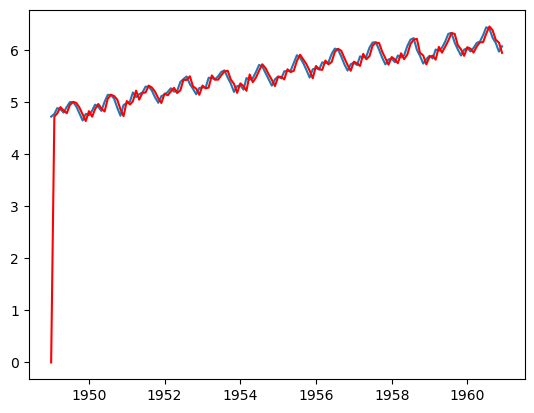

In [46]:

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model1 = ARIMA(airpass_log, order=(2, 1, 0))
results_AR = model1.fit()
plt.plot(airpass_log)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - airpass_log['Passengers'])**2))
print('Plotting AR model')


KeyError: 'Passengers'

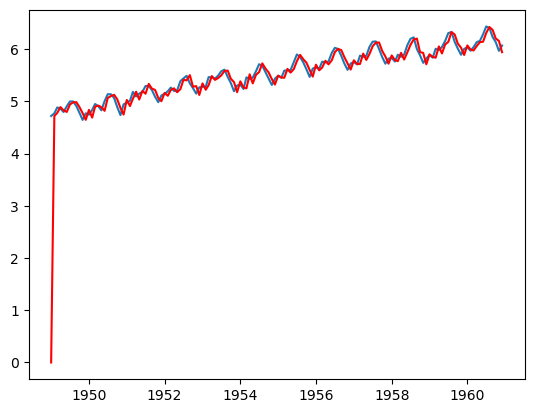

In [47]:
model2 = ARIMA(airpass_log, order=(0,1,2))
results_MA = model2.fit()
plt.plot(airpass_log)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - airpass_log['Passengers'])**2))
print('Plotting MA model')

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

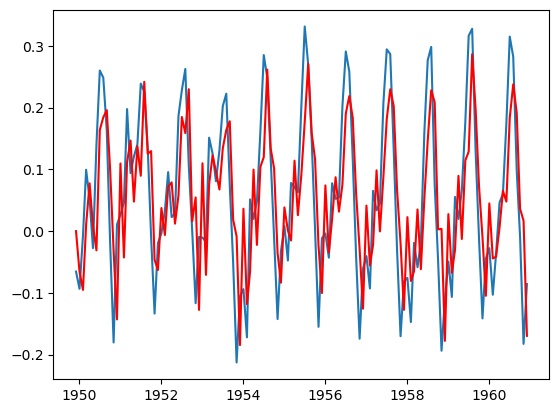

In [45]:

model = ARIMA(airpass_log_diff, order=(2, 1, 2))
results_ARIMA = model.fit()

plt.plot(airpass_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - airpass_log_diff) ** 2))
plt.show()


KeyError: 'Passengers'

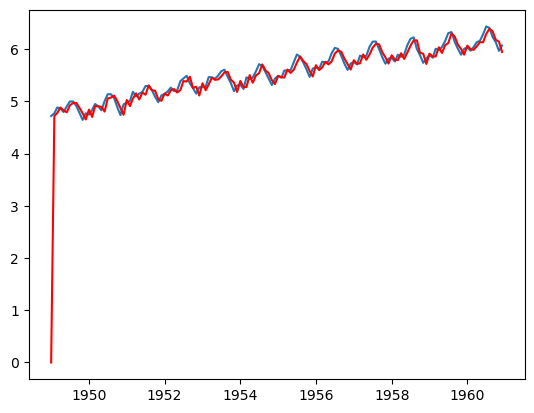

In [48]:
model = ARIMA(airpass_log, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(airpass_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - airpass_log['Passengers'])**2))
print('Plotting ARIMA model')

In [49]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()


Month
1949-01-01    0.000000
1949-02-01    4.718499
1949-03-01    4.776385
1949-04-01    4.883215
1949-05-01    4.824422
dtype: float64

In [50]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-01-01     0.000000
1949-02-01     4.718499
1949-03-01     9.494884
1949-04-01    14.378098
1949-05-01    19.202520
dtype: float64

In [52]:
predictions_ARIMA_log = pd.Series(airpass_log['#Passengers'].iloc[0], index=airpass_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01     4.718499
1949-02-01     9.436998
1949-03-01    14.213382
1949-04-01    19.096597
1949-05-01    23.921019
dtype: float64

In [53]:
airpass_log.head()

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


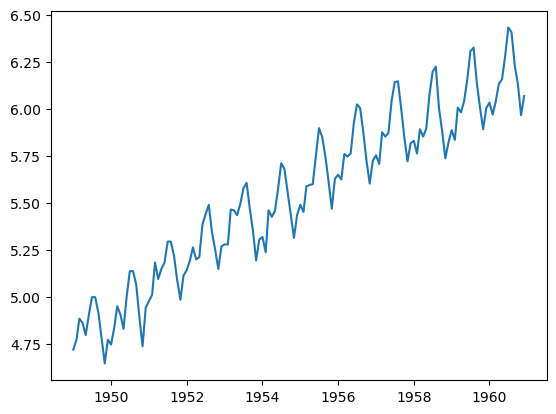

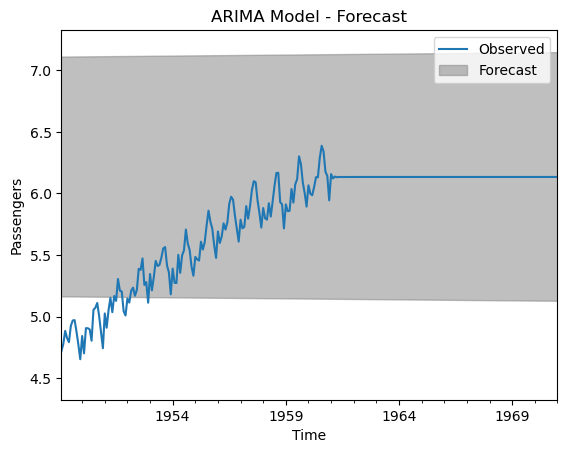

In [54]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Assuming you have already defined and trained the ARIMA model
model = ARIMA(airpass_log, order=(2, 1, 2))
results_ARIMA = model.fit()

plt.plot(airpass_log)
plot_predict(results_ARIMA, start=1, end=264)
plt.title('ARIMA Model - Forecast')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend(['Observed', 'Forecast'])
plt.show()

In [59]:
from datetime import datetime
airpass['Month']=pd.to_datetime(airpass['Month'],infer_datetime_format=True)


In [61]:
airpass.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [62]:
airpass.tail()

,Month,#Passengers
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432
